<a href="https://colab.research.google.com/github/msiplab/AtipWork/blob/master/python/sample_ksvd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 辞書学習（K-SVD）演習

Copyright (C) 2024 Shogo MURAMATSU, All rights reserved

準備

In [1]:
%pip install pandas
%pip install japanize-matplotlib
%pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=2ca598acfa0a37eefa44ff0548020842c0f1d195341185d8fc0195c181ef2140
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


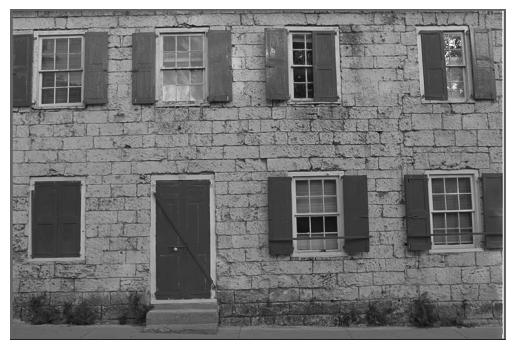

画像のサイズ: (512, 768)


In [2]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

# URLから画像を取得してNumPy配列に変換
def fetch_image_as_array(url):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        return np.array(image)  # NumPy配列に変換
    else:
        raise Exception(f"Failed to fetch the image. Status code: {response.status_code}")

# 画像を取得
url = 'https://www.r0k.us/graphics/kodak/kodak/kodim01.png'
image_array = fetch_image_as_array(url)

# グレースケール化
gray_image = Image.fromarray(image_array).convert('L')
gray_image_array = np.array(gray_image)

# 画像を表示
plt.imshow(gray_image_array, cmap='gray')
plt.axis('off')
plt.show()

# 画像のサイズを表示
print(f"画像のサイズ: {gray_image_array.shape}")


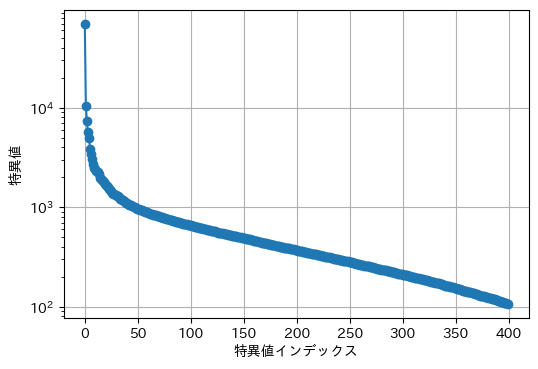

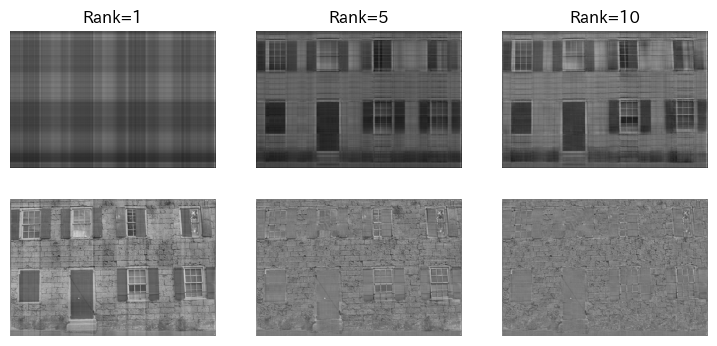

In [3]:
# gray_image_arrayの特異値分解
U, Sgm, Vt = np.linalg.svd(gray_image_array)

# 特異値を降順でプロット(特異値400番目まで)
plt.figure(figsize=(6, 4))
plt.plot(Sgm[:400], marker='o')
plt.xlabel('特異値インデックス')
plt.ylabel('特異値')
plt.yscale('log')
plt.grid()
plt.show()

# 近似ランク1から100まで、20刻みで画像を復元してモンタージュ表示
# 近似誤差画像も併せて表示
approximation_ranks = [1, 5, 10]
fig, axs = plt.subplots(2, 3, figsize=(9, 4))
for i, rank in enumerate(approximation_ranks):
    approx_image_array = U[:, :rank] @ np.diag(Sgm[:rank]) @ Vt[:rank, :]
    approx_error_image_array = gray_image_array - approx_image_array
    axs[0, i].imshow(approx_image_array, cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Rank={rank}')
    axs[1, i].imshow(approx_error_image_array, cmap='gray')
    axs[1, i].axis('off')

### パラメータ設定

-  冗長率 (Redundancy ratio)
-  スパース率 (Sparsity ratio)
-  繰返し回数 (Number of iterations)

In [4]:
# 冗長度
redundancyRatio = 1/8

# スパース度
sparsityRatio = 1/64

# 繰り返し回数
nItersKsvd = 20

## 音響データからのデータ行列 $\mathbf{Y}$の生成

-  $\mathbf{Y}\in {\mathbb{R}}^{N\times S}$

サンプリングレート: 22050 Hz


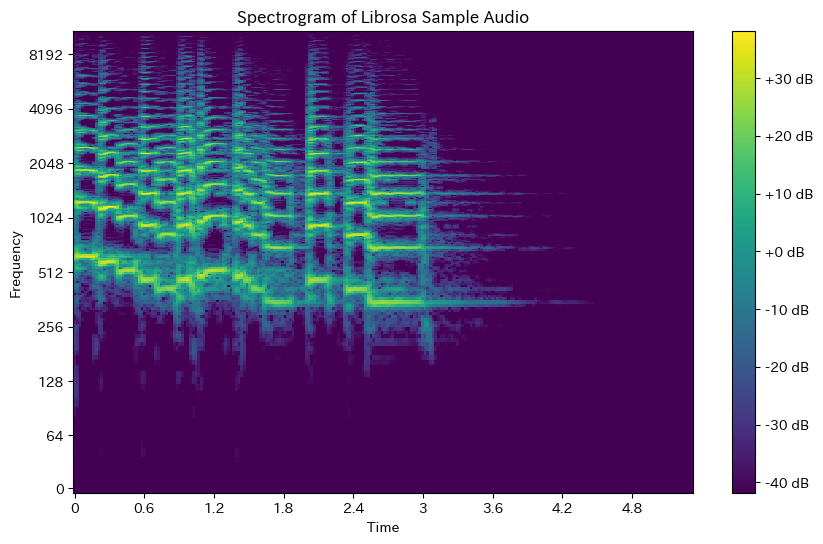

スペクトログラムのサイズ: (1025, 230)


In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Librosa付属の音声データをロード
y, sr = librosa.load(librosa.ex('trumpet'))
print(f"サンプリングレート: {sr} Hz")

# スペクトログラムの計算
S = librosa.stft(y)  # 短時間フーリエ変換
Y = np.abs(S)  # 振幅スペクトル
Y_db = librosa.amplitude_to_db(Y)  # 振幅をdBスケールに変換

# スペクトログラムのプロット
plt.figure(figsize=(10, 6))
librosa.display.specshow(Y_db, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Librosa Sample Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# スペクトログラムのサイズを表示
print(f"スペクトログラムのサイズ: {Y_db.shape}")

### K\-特異値分解


#### 問題設定:

$$
\begin{aligned}
& \lbrace \hat{{\mathbf{D} }} ,\lbrace {\hat{\mathbf{x}} }_n \rbrace \rbrace =\arg \min_{\lbrace {\mathbf{D} },\lbrace x_n \rbrace \rbrace } \frac{1}{2S}\sum_{n=1}^S \|\mathbf{y}_n -{\mathbf{D} }{\hat{x} }_n {\|}_2^2 , \\
& {\mathrm{s}.\mathrm{t}.}~\forall n,\|x_n {\|}_0 \le K\newline  \end{aligned}$$
#### アルゴリズム:

スパース近似ステップと辞書更新ステップを繰返す．

-  スパース近似ステップ


$${\hat{\mathbf{x}} }_n =\arg \min_{x_n } \frac{1}{2}\|y_n -\hat{{\mathbf{D} }} x_n {\|}_2^2 ~~~{\mathrm{s}.\mathrm{t}.}~\|x_n {\|}_0 \le K$$

-  辞書更新ステップ


$$\hat{{\mathbf{D} }} =\arg \min_{{\mathbf{D} }} \frac{1}{2S}\sum_{n=1}^S \|y_n -{\mathbf{D} }\hat{\mathbf{x} }_n {\|}_2^2 =\arg \min_{{\mathbf{D} }} \frac{1}{2S}{\left\|\left(Y-\sum_{p\not= k} {{\mathbf{d} }}_p {\hat{X} }_{p,\colon } \right)-{{\mathbf{d} }}_k {\hat{X} }_{k,\colon } \right\|}_F^2$$


In [6]:
# Y の行数
nDims = Y.shape[0]

# アトムの数
nAtoms = np.ceil(redundancyRatio * nDims).astype(int)

# 係数の数
nCoefsKsvd = max(np.floor(sparsityRatio * nDims).astype(int), 1)

print(f"アトムの数: {nAtoms}")
print(f"係数の数: {nCoefsKsvd}")

アトムの数: 129
係数の数: 16



辞書 ${\mathbf{D} }$ の初期化

-  ランダム（一様分布）

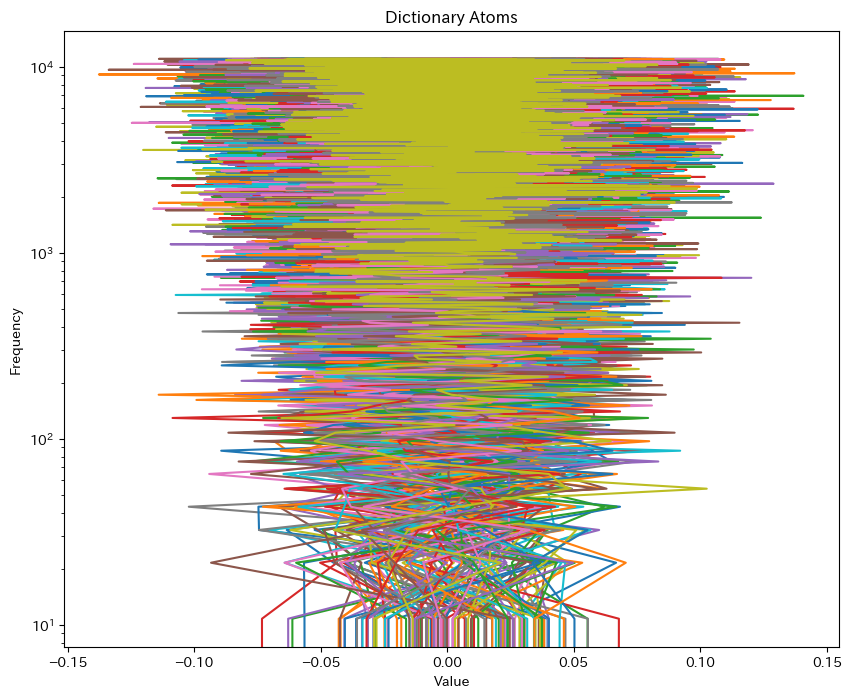

In [7]:
# ランダム初期化
D = np.random.randn(nDims, nAtoms)
D /= np.linalg.norm(D, axis=0) # 列ベクトルのノルムが1になるように正規化

# 初期辞書を表示
plt.figure(figsize=(10, 8))
for i in range(D.shape[1]):
    plt.plot(D[:, i], (sr/2)*np.arange(D.shape[0])/D.shape[0], label=f'Atom {i+1}')
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title('Dictionary Atoms')
plt.show()



#### スパース近似ステップと辞書更新ステップの繰り返し

-  スパース近似： 直交マッチング追跡 (OMP)
-  辞書更新： 特異値分解と1\-ランク近似 (SVD and 1\-rank approximation)

辞書更新の内容

1.  $\displaystyle k\gets 1$
2. 誤差行列 $E_k$ を定義： $E_k \colon =Y-\sum_{p\not= k} {{\mathbf{d} }}_p {\hat{X} }_{p,\colon }$
3. データ行 ${\hat{X} }_{k,\colon }$ の非零値を抽出する行列 ${{\Omega }}_k$ を定義： ${\hat{X} }_{k,\colon }^R ={\hat{X} }_{k,\colon } {{\Omega }}_k \Leftrightarrow {\hat{X} }_{k,\colon }^R {{\Omega }}_k^T ={\hat{X} }_{k,\colon }$
4. 誤差行列 $E_k$ を行列 ${{\Omega }}_k$ で縮退： $E_k^R \colon =E_k {{\Omega }}_k$
5. 縮退した誤差行列 $E_k^R$ を特異値分解： $E_k^R =USV^T =\left(u_1 ,u_2 ,\cdots ,u_r \right){\mathrm{d}\mathrm{i}\mathrm{a}\mathrm{g}}(\sigma_1 ,\sigma_2 ,\cdots ,\sigma_r ){\left(v_1 ,v_2 ,\cdots ,v_r \right)}^T$
6. 要素ベクトル ${{\mathbf{d} }}_k$ を更新： $k\gets u_1$
7. データ行 ${\hat{X} }_{k,\colon }$ を更新： ${\hat{X} }_{k,\colon } \gets \sigma_1 v_1^T$
8. $\displaystyle k\gets k+1$
9. $k\le N$ ならば 2. へ $k>N$ ならば終了

ただし， $\sigma_1$ を最大特異値とする．



### 直交マッチング追跡関数

In [8]:
def omp(y, D, nCoefs):
    # 初期化
    N = D.shape[0]
    K = nCoefs

    # 直交マッチング追跡(OMP)法／マッチング追跡(MP)法
    # 初期化
    L = D.shape[1]
    e = np.ones(L)
    z = np.zeros(L)
    g = np.zeros(L)
    x = np.zeros(L)
    ty = np.zeros(N)
    r = y - ty
    supp = []

    for k in range(K):
        # マッチング処理
        for p in range(L):
            d = D[:, p]
            g[p] = d.T @ r
            z[p] = g[p] / np.linalg.norm(d)**2  # (d.T @ d)
            e[p] = np.linalg.norm(r)**2 - g[p] * z[p]  # r.T @ r - g[p] * z[p]
        # 最小値探索（追跡）
        mmin = np.argmin(e)
        # サポート更新
        supp = list(set(supp) | {mmin})
        Ds = D[:, supp]
        x[supp] = np.linalg.pinv(Ds) @ y
        # 残差成分
        ty = D @ x
        r = y - ty

    return x

#### 交互ステップの繰返し計算

In [9]:
# データ行列の中心化
Ym = np.mean(Y, axis=1, keepdims=True) # 平均
Yc = Y - Ym # 中心化

# K-SVD
cost = np.zeros(nItersKsvd) # コストを格納する配列
nSamples = Yc.shape[1]
for iIter in range(nItersKsvd):
    X = np.zeros((nAtoms, nSamples))
    print(r'Iteration %4d/%4d'%(iIter+1,nItersKsvd))

    # スパース近似
    for iSample in range(nSamples):
        print(r'   Sample %4d/%4d'%(iSample+1,nSamples), end='\r')
        # 1サンプルのスパース近似
        y = Yc[:, iSample] # サンプル
        x = omp(y,D,nCoefsKsvd) # OMP
        X[:, iSample] = x # 係数

    # 辞書更新
    for iAtom in range(nAtoms):
        print(r'     Atom %4d/%4d'%(iAtom+1,nAtoms), end='\r')
        xk = X[iAtom, :] # k番目のアトムの係数群
        suppk = np.where(np.abs(xk) > 1e-10)[0] # 係数が非ゼロのサンプルのインデックス
        # 縮退した残差行列
        Ekred = Yc[:,suppk] - (D @ X[:,suppk] - np.outer(D[:, iAtom], xk[suppk]))
        # 残差行列が非ゼロの場合
        if Ekred.shape[1] > 0:
            U, S, Vt = np.linalg.svd(Ekred) # 特異値分解
            ak = U[:, 0] # 新しいアトム
            xkred = S[0] * Vt[0, :] # 新しいアトムの係数
            #
            D[:, iAtom] = ak # アトムの更新
            xkred_full = np.zeros_like(xk) # 係数のフルサイズ
            xkred_full[suppk] = xkred # 係数のフルサイズの更新
            X[iAtom, :] = xkred_full # 係数の更新
    # コスト計算
    Ek = Yc - D @ X # 残差行列
    cost[iIter] = np.linalg.norm(Ek, 'fro')**2/(2*nSamples) # コストの記録



Iteration    1/  20
Iteration    2/  20
Iteration    3/  20
Iteration    4/  20
Iteration    5/  20
Iteration    6/  20
Iteration    7/  20
Iteration    8/  20
Iteration    9/  20
Iteration   10/  20
Iteration   11/  20
Iteration   12/  20
Iteration   13/  20
Iteration   14/  20
Iteration   15/  20
Iteration   16/  20
Iteration   17/  20
Iteration   18/  20
Iteration   19/  20
Iteration   20/  20


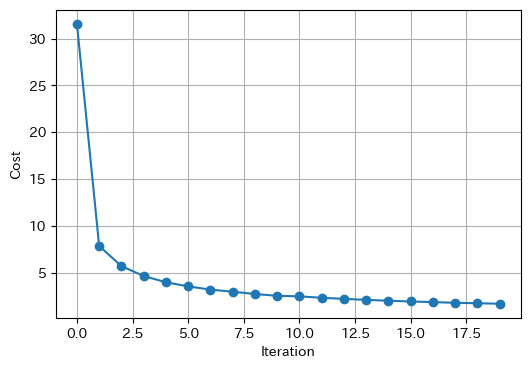

In [10]:
# コスト評価のグラフ
plt.figure(figsize=(6, 4))
plt.plot(cost, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid()
plt.show()

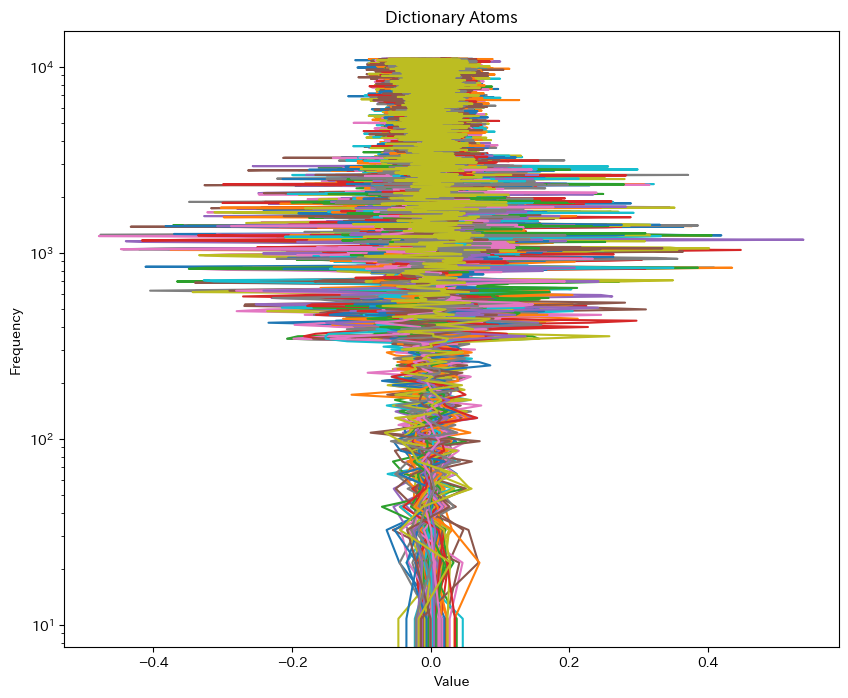

In [11]:
# 学習辞書を表示
plt.figure(figsize=(10, 8))
for i in range(D.shape[1]):
    plt.plot(D[:, i], (sr/2)*np.arange(D.shape[0])/D.shape[0], label=f'Atom {i+1}')
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title('Dictionary Atoms')
plt.show()

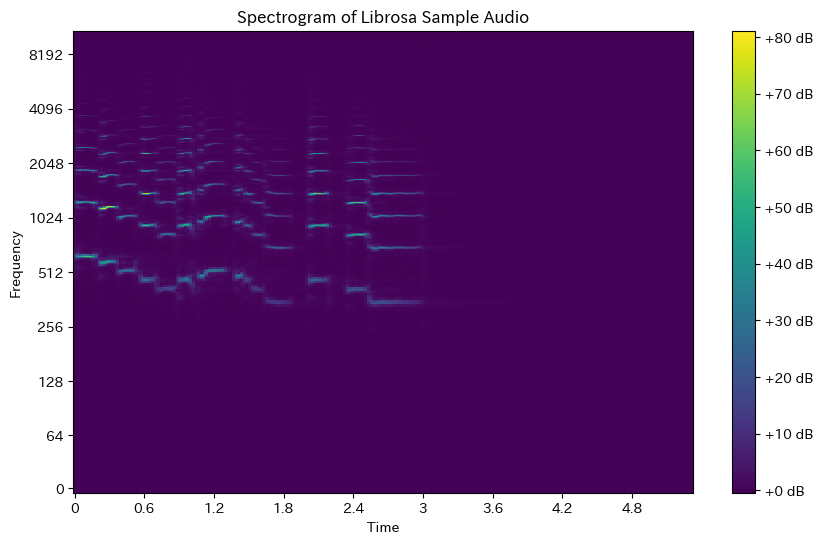

In [12]:
# スペクトログラムのプロット
plt.figure(figsize=(10, 6))
librosa.display.specshow(D@X+Ym, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Librosa Sample Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

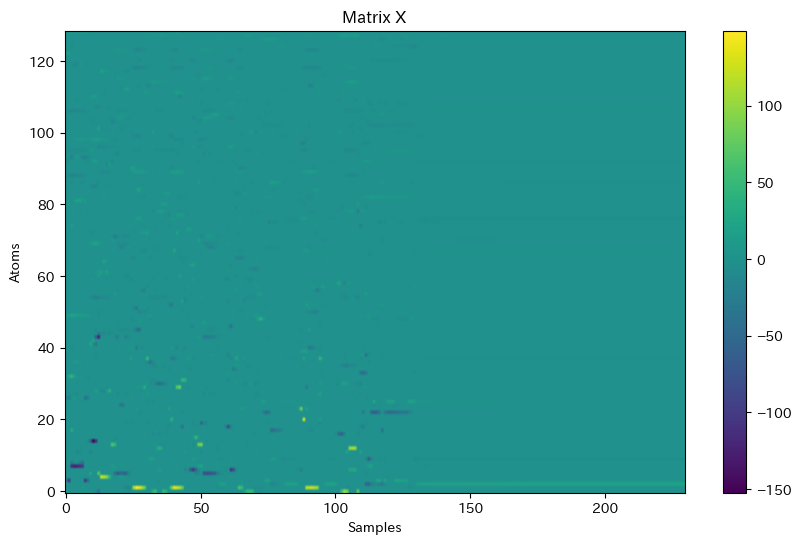

In [13]:
# Xを画像としてプロット
plt.figure(figsize=(10, 6))
plt.imshow(X, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Matrix X')
plt.xlabel('Samples')
plt.ylabel('Atoms')
plt.show()